# Sequências - Aula Prática
## Embeddings

Neste notebook iremos trabalhar um pouco com a parte introdutória de modelos de linguagem, realizando **analogias** a partir de representações distribuídas (*embeddings*) geradas pelo algoritmo de aprendizagem não-supervisionada `GloVe` (*Global Vectors for Word Representation*).
> Para saber mais sobre como o `GloVe` funciona, recomendo a leitura do seguinte [notebook](https://colab.research.google.com/github/jaygala24/pytorch-implementations/blob/master/Global%20Vectors%20for%20Word%20Representation.ipynb#scrollTo=oEXgG-hDIMdT). Esse notebook prático não tem como foco explicar como que o algoritmo funciona, mas sim explicar as operações que podemos fazer com as representações distribuídas geradas por algoritmos de *word embedding*.

- Este notebook foi inspirado pelos trabalhos disponibilizados nos sites [d2l.ai](https://d2l.ai/chapter_natural-language-processing-pretraining/similarity-analogy.html) e [notebook.community](https://notebook.community/spro/practical-pytorch/glove-word-vectors/glove-word-vectors).

- **Importante:** caso esteja rodando esse notebook no ambiente da Tatu, favor executar a seguinte célula. Caso contrário, basta ignorar a sua execução.

In [ ]:
%load_ext nbproxy

Chave:  ej0f
Senha: ········



Variáveis de ambiente http_proxy e https_proxy configuradas!


Definindo um diretório temporário para salvar dados e eventuais saídas de modelos.
> Lembre-se de executar a última célula deste notebook para apagar esse diretório temporário.

In [1]:
import tempfile
tmp = tempfile.TemporaryDirectory()

print('Nome do diretório temporário:', tmp.name)

Nome do diretório temporário: /tmp/tmpwmet0him


## Importação de pacotes

In [ ]:
!pip install torch==2.3.1+cu121 torchaudio==2.3.1+cu121 torchtext==0.18.0 torchvision==0.18.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html

In [11]:
import torch
import torchtext

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join as ospj
from torch.utils.data import Dataset

sns.set_style('dark')

## Analogias

Analogias são associações de mesma natureza entre palavras (como flexões de gênero ou número). A geometria dessas associações pode ser visualizada no espaço vetorial onde as palavras são projetadas e, em modelos bem treinados, deve ser possível encontrar semelhanças entre associações de mesma natureza.

<img width=800 src="https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/analogias.png?raw=true"/>

Ao longo deste notebook, utilizaremos o modelo `GloVe` para realizar a projeção de palavras em um espaço vetorial. Mais especificamente, usaremos o módulo `torchtext` para carregar um modelo pré-treinado em uma base de dados de 6 bilhões de tokens, realizando uma projeção das palavras em um espaço 100 dimensional.

### Carregamento de um modelo GloVe pré-treinado

Iremos utilizar a classe `torchtext.vocab.GloVe` para carregar um modelo `GloVe` pré-treinado.

> O modelo retornado pelo `torchtext` possui alguns atributos, como o dicionário `stoi` (*string* to *int*) para mapear uma palavra para um índice numérico e a lista `itos` (*int* to *string*), mapeando um índice númerico para uma palavra. Além disso, conseguimos acessar a matriz de *embeddings* através do atributo `vectors`.

In [10]:
glove = torchtext.vocab.GloVe(name='6B', dim=100, cache=tmp.name)

random_tokens = np.random.choice(glove.itos, size=5)

print('Número de tokens mapeados pelo glove.6B.100d:', len(glove.stoi))
print('Aqui temos 5 tokens aleatórios mapeados pelo glove.6B.100d:', random_tokens)
print('A dimensionalidade da matriz de embeddings é:', glove.vectors.shape)

/tmp/tmpwmet0him/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:20<00:00, 19102.64it/s]


Número de tokens mapeados pelo glove.6B.100d: 400000
Aqui temos 5 tokens aleatórios mapeados pelo glove.6B.100d: ['çay' 'kaust' 'steinem' 'mauney' 'materialist']
A dimensionalidade da matriz de embeddings é: torch.Size([400000, 100])


### Projeções vetoriais utilizando o GloVe

Podemos realizar projeções de palavras utilizando a matriz de *embeddings* computada pelo `glove.6B.100d` através do método `get_vecs_by_tokens`, como visto a seguir.

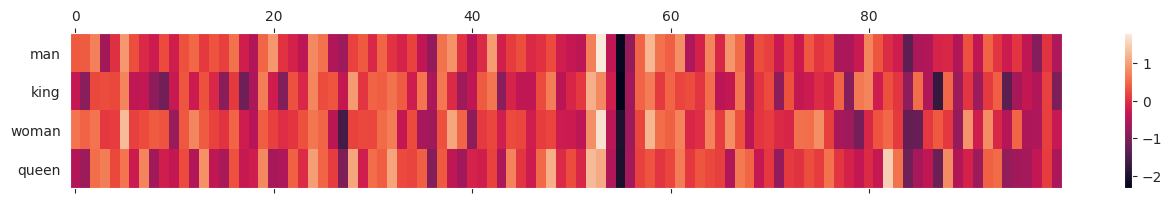

In [12]:
tokens = ['man', 'king', 'woman', 'queen']
vecs = glove.get_vecs_by_tokens(tokens)

plt.matshow(vecs, aspect='auto')
plt.yticks(range(4), tokens)
plt.colorbar()
plt.show()

Percebemos que o GloVe também possui alguns *tokens* bem específicos sobre algumas áreas do conhecimento, como a palavra **maastrichtian** (geologia).

In [13]:
glove.get_vecs_by_tokens(['maastrichtian'])

tensor([[ 0.3150,  0.1135,  0.5784,  0.4795, -0.6270, -0.3095,  0.3571,  0.8003,
         -0.9345, -0.2244,  0.1809,  0.5689, -0.3878, -0.2653,  0.9437, -0.1408,
         -0.4315, -1.1660,  0.8629,  0.0358, -0.1991,  0.0430, -0.6874,  0.7941,
         -0.2028, -0.1681,  1.1595, -0.1284,  0.5942, -0.2853, -0.3330, -0.5052,
         -0.1974, -0.7642,  0.1781, -0.0454, -0.0794, -0.9932,  0.6806, -0.1139,
         -0.6568,  0.9910, -0.4612,  0.3818, -0.2073, -0.3484, -0.2102,  0.4532,
         -0.5074, -0.4104,  0.3166,  0.0311,  0.1852, -0.9361,  0.0542, -0.4014,
         -1.1321, -0.4270, -0.4654,  0.1946,  0.7885,  1.2777,  0.2701,  0.2475,
          0.5816,  0.1083,  0.2401, -1.4185, -0.9999, -0.9238,  0.5028, -0.4187,
         -0.7585, -0.0235, -1.3397, -0.3581, -0.7843,  0.0928,  0.2622, -0.3728,
         -0.3929,  0.1143,  0.9144, -0.3808,  0.4052,  0.5633, -0.1548, -0.0513,
         -0.0401,  0.4397,  0.1842,  0.1656, -0.3675,  0.8278,  0.0674,  0.4581,
         -0.0159, -0.4071,  

Caso o GloVe não tenha um *token* mapeado, não encontramos nenhum erro, apenas um *embedding* de zeros.
> Talvez o *token* **pre-salt** possa aparecer em modelos maiores: como o `glove.840B.300d`, por ter sido treinado num *corpus* bem maior (840 bilhões de *tokens*) do que o que estamos utilizando nesse notebook.

In [14]:
glove.get_vecs_by_tokens(['pre-salt'])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])

Além disso, podemos visualizar esses vetores no espaço latente para analisar algumas propriedades interessantes. Para tornar a visualização factível, podemos utilizar um algoritmo de redução de dimensionalidade.

> Para esse exemplo iremos utilizar o algoritmo de redução de dimensionalidade PCA (*Principal Components Analysis*), devido a uma melhor interpretabilidade para o exemplo escolhido. Porém, é mais comum vermos algoritmos como o t-SNE (*t-distributed Stochastic Neighbor Embedding*), uma vez que este algoritmo preserva a estrutura local do dado original. Para mais detalhes na diferença entre t-SNE e PCA, recomendo a leitura do seguinte [link](https://medium.com/analytics-vidhya/pca-vs-t-sne-17bcd882bf3d).

In [15]:
from sklearn.decomposition import PCA

tokens = ['man', 'woman', 'king', 'queen', 'brother', 'sister']
vecs = glove.get_vecs_by_tokens(tokens)

# Calculando a redução de dimensionalidade para um espaço bidimensional
pca = PCA(n_components=2)
components = pca.fit_transform(vecs.numpy())

print('Tamanho dos componentes:', components.shape)

Tamanho dos componentes: (6, 2)


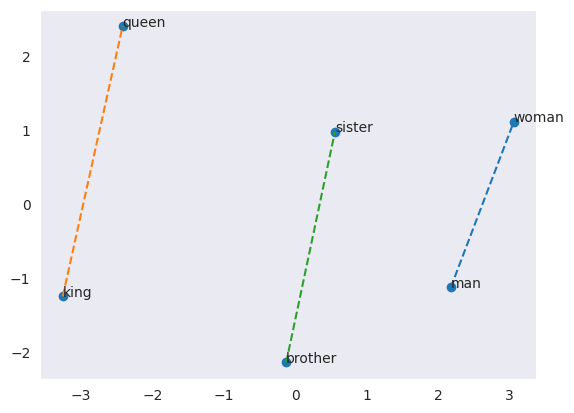

In [16]:
fig, ax = plt.subplots()
ax.scatter(components[:, 0], components[:, 1])

for i, token in enumerate(tokens):
    ax.annotate(token, (components[i, 0], components[i, 1]))

for i in range(0, len(tokens) - 1, 2):
    x = (components[i, 0], components[i+1, 0])
    y = (components[i, 1], components[i+1, 1])
    ax.plot(x, y, linestyle='--')

Note pela imagem acima como a operação vetorial: $(\overrightarrow{\text{king}} - \overrightarrow{\text{queen}}) + \overrightarrow{\text{sister}} \approx \overrightarrow{\text{brother}}$.

In [17]:
king = components[tokens.index('king')]
queen = components[tokens.index('queen')]
sister = components[tokens.index('sister')]
brother = components[tokens.index('brother')]

result = (king - queen) + sister
print('Vetor resultante:', result)
print('Vetor para a palavra "brother":', brother)

Vetor resultante: [-0.28107953 -2.6646426 ]
Vetor para a palavra "brother": [-0.1251936 -2.1323261]


<br> Podemos refazer o plot para verificar onde a posição do vetor resultante.

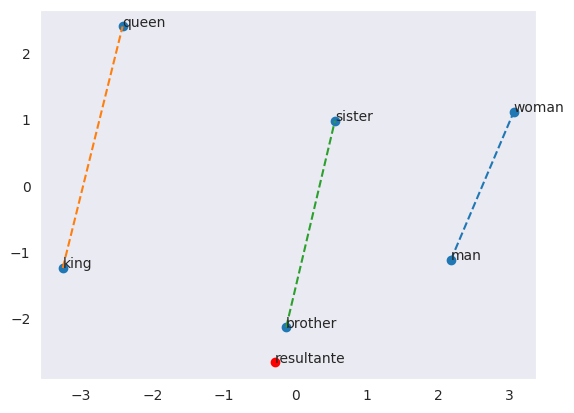

In [18]:
fig, ax = plt.subplots()

# Adicionando o ponto do vetor resultante
ax.scatter(result[0], result[1], color='red')
ax.annotate('resultante', (result[0], result[1]))

ax.scatter(components[:, 0], components[:, 1])

for i, token in enumerate(tokens):
    ax.annotate(token, (components[i, 0], components[i, 1]))

for i in range(0, len(tokens) - 1, 2):
    x = (components[i, 0], components[i+1, 0])
    y = (components[i, 1], components[i+1, 1])
    ax.plot(x, y, linestyle='--')

### Realizando analogias através do GloVe

Através de operações vetoriais, como visto anteriormente, somos capazes de criar analogias no espaço latente da nossa representação distribuída, conseguindo responder perguntas como: `rainha está para rei assim como irmã está para ???`.

Possuímos diversas estratégias para retornar a palavra correta para tal pergunta. Por exemplo, a partir da imagem da célula anterior, uma possível estratégia é de calcular o top-1 vizinho mais próximo do vetor resultante através de um algoritmo de `KNN`, porém tal estratégia pode ser menos viável em dimensões maiores devido à [maldição da dimensionalidade](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6065061). Para esse notebook, iremos utilizar uma estratégia que envolve a similaridade de cosseno entre os vetores no espaço latente, selecionando como analogia aquele vetor com maior similaridade.

A similaridade de cosseno pode ser computada através da seguinte equação, onde temos uma operação de similaridade no numerador (produto interno), dividido pelo produto da norma de cada vetor. Também introduzimos um fator $\epsilon \approx 1\mathrm{e}{-6}$ no denominador como um termo para evitar divisão por zero. A distância, ou similaridade, de cosseno possui imagem entre $[-1, +1]$, onde $-1$ indica que os vetores estão apontados para sentidos opostos; $+1$ indica que os vetores estão apontando para a mesma direção; e $0$ indica que os vetores são perpendiculares.

$$
\text{similaridade} = \frac{\overrightarrow{x_1} \cdot \overrightarrow{x_2}}{\max(\lVert \overrightarrow{x_1} \rVert_2 * \lVert \overrightarrow{x_2} \rVert_2, \epsilon)}
$$

Primeiramente, iremos observar os top vetores retornados pela distância de cosseno a partir de uma *query* (palavra) fornecida.

1. Implemente a função `get_similar_tokes`. Ela deve retornar um array com os tokens mais próximos de *query*.

In [19]:
def get_similar_tokens(query, embedding, k=10):
    query_vector = embedding.get_vecs_by_tokens(query)
    query_vector = query_vector.unsqueeze(dim=0)  # adicionando uma dimensão para casar com as dimensões do embeddings

    cosine = nn.CosineSimilarity(dim=1)
    similarities = cosine(query_vector, embedding.vectors)

    result = []
    values, indices = torch.topk(similarities, k=k+1)  # a query será mais similar com ela mesma, por isso iremos usar k+1
    for value, index in zip(values[1:], indices[1:]):
        token = embedding.itos[index]
        result.append((token, value))

    return result

similar_tokens = get_similar_tokens('computer', glove, k=5)
for i, (token, similarity) in enumerate(similar_tokens):
    print(f'{i+1}. {token} -> {similarity:.5f}')

1. computers -> 0.87520
2. software -> 0.83731
3. technology -> 0.76422
4. pc -> 0.73664
5. hardware -> 0.72904


<br> Agora iremos utilizar a distância de cosseno para computar analogias.

2. Implemente a função `get_topk_analogies`.

In [20]:
def get_topk_analogies(token1, token2, token3, embedding, k=5):
    """
    A ordem dos tokens passados é: <token1> está para <token2> assim como <token3> está para...
    """
    vecs = embedding.get_vecs_by_tokens([token1, token2, token3])
    result = (vecs[1] - vecs[0]) + vecs[2]
    result = result.unsqueeze(dim=0)  # adicionando uma dimensão para casar com as dimensões do embeddings

    cosine = nn.CosineSimilarity(dim=1)
    similarities = cosine(result, embedding.vectors)

    result = []
    values, indices = torch.topk(similarities, k=k+1)  # a query será mais similar com ela mesma, por isso iremos usar k+1
    for value, index in zip(values, indices):
        token = embedding.itos[index]
        result.append((token, value))

    return result

get_topk_analogies('queen', 'king', 'wife', glove)

[('son', tensor(0.8607)),
 ('brother', tensor(0.8473)),
 ('father', tensor(0.8420)),
 ('wife', tensor(0.7959)),
 ('husband', tensor(0.7948)),
 ('nephew', tensor(0.7712))]

In [21]:
get_topk_analogies('beijing', 'china', 'tokyo', glove)

[('japan', tensor(0.8508)),
 ('tokyo', tensor(0.8389)),
 ('japanese', tensor(0.7080)),
 ('asia', tensor(0.6950)),
 ('china', tensor(0.6839)),
 ('singapore', tensor(0.6535))]

In [22]:
get_topk_analogies('do', 'does', 'go', glove)

[('goes', tensor(0.9019)),
 ('comes', tensor(0.8339)),
 ('does', tensor(0.8284)),
 ('go', tensor(0.8181)),
 ('takes', tensor(0.7971)),
 ('if', tensor(0.7899))]

## *Fine-tuning* de *embeddings* pré-treinados

No mundo de processamento de linguagem natural, é muito comum utilizarmos *embeddings* pré-treinados como um pontapé inicial para a nossa rede, muito por conta desses *embeddings* serem treinados em uma base de dados imensa, necessitando de muito poder computacional se quisermos treinar os nossos próprios *embeddings* do zero.

Caso você queira utilizar os pesos pré-treinados do `GloVe`, ou de qualquer outro modelo pré-treinado, em uma camada `nn.Embedding` do seu modelo, você pode inicializar os pesos dessa camada através da função `.from_pretrained`, como ilustrado a seguir.

In [23]:
my_embedding = nn.Embedding.from_pretrained(glove.vectors)
my_embedding.weight

Parameter containing:
tensor([[-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        [-0.1077,  0.1105,  0.5981,  ..., -0.8316,  0.4529,  0.0826],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.3609, -0.1692, -0.3270,  ...,  0.2714, -0.2919,  0.1611],
        [-0.1046, -0.5047, -0.4933,  ...,  0.4253, -0.5125, -0.1705],
        [ 0.2837, -0.6263, -0.4435,  ...,  0.4368, -0.8261, -0.1570]])

<br>Também temos a opção de manualmente dizer que queremos que esses pesos sofram um *fine-tuning* ao longo do treinamento.

> Por padrão, os pesos do modelo pré-treinado são "congelados", indicando que eles não sofrerão atualizações via *backpropagation*.

In [24]:
my_embedding = nn.Embedding.from_pretrained(glove.vectors, freeze=False)
my_embedding.weight

Parameter containing:
tensor([[-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        [-0.1077,  0.1105,  0.5981,  ..., -0.8316,  0.4529,  0.0826],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.3609, -0.1692, -0.3270,  ...,  0.2714, -0.2919,  0.1611],
        [-0.1046, -0.5047, -0.4933,  ...,  0.4253, -0.5125, -0.1705],
        [ 0.2837, -0.6263, -0.4435,  ...,  0.4368, -0.8261, -0.1570]],
       requires_grad=True)

In [25]:
# Rode essa célula para apagar o diretório temporário
tmp.cleanup()